In [1]:
# install fastkaggle if not available
try:
    import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle
try:
    import tqdm
except ModuleNotFoundError:
    !pip install tqdm
try:
    import pydicom
except ModuleNotFoundError:
    !pip install pydicom

from fastkaggle import *
from fastai.vision.all import *
from tqdm.notebook import tqdm
import pydicom


c:\Users\mipbk\anaconda3\envs\myenv\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
comp = "rsna-pneumonia-detection-challenge"
path = setup_comp(comp, install='fastai "timm>=0.6.2.dev0"')

In [3]:
labels = pd.read_csv(path/"stage_2_train_labels.csv")
labels = labels.drop_duplicates("patientId")
labels.head()

patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [86]:
train_path = Path("data")
if not os.path.exists(train_path):
    os.makedirs(train_path)
    os.makedirs(train_path/"0")
    os.makedirs(train_path/"1")

## Preprocess

In [87]:
# Only process if no files in folder
files = get_image_files(train_path)
if len(files) == 0:
    for c, patient_id in enumerate(tqdm(labels.patientId)):
        label = labels.Target.iloc[c]
        dcm = pydicom.read_file(path/f"stage_2_train_images/{patient_id}.dcm").pixel_array #/ 255
        # dcm = cv2.resize(dcm, (224, 224))#.astype(np.float16)
        img = Image.fromarray(dcm).convert("L")
        if label == 0:
            img.save(train_path/f"0/{patient_id}.jpg")
        elif label == 1:
            img.save(train_path/f"1/{patient_id}.jpg")

In [88]:
files = get_image_files(train_path)

(1024, 1024)


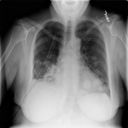

In [89]:
img = PILImage.create(files[0])
print(img.size)
img.to_thumb(128)

In [90]:
# from fastcore.parallel import *
# def f(o): return PILImage.create(o).size
# sizes = parallel(f, files, n_workers=6)
# pd.Series(sizes).value_counts()

## Classification

In [61]:
# # get a subset of data
# import pathlib
# src = train_path
# dst = train_path/'_subset'
# dir_path = r'C:\path\to\directory'
# dst_path = r'C:\path\to\destination\directory'
# max_files = 100

# files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]

# for i, file in enumerate(files):
#     if i >= max_files:
#         break
#     src_file = os.path.join(dir_path, file)
#     dst_file = os.path.join(dst_path, file)
#     shutil.copy2(src_file, dst_file)


# # train_path = dst


['0', '1']


1000

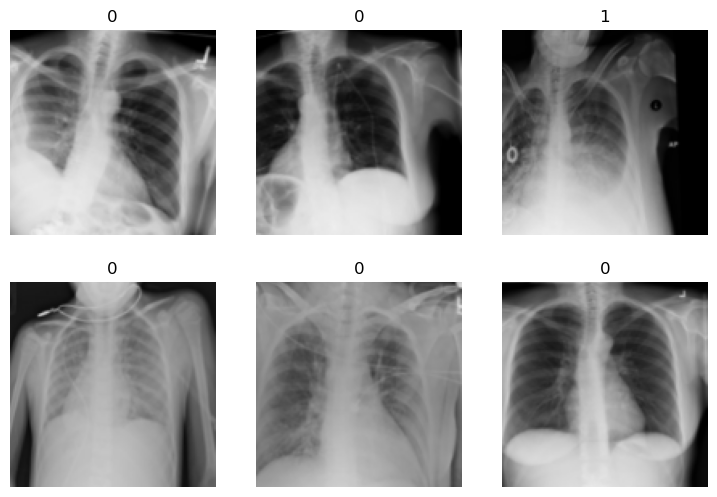

In [41]:
dls = ImageDataLoaders.from_folder(train_path, 
                                   valid_pct=0.2,
                                   item_tfms=Resize(192),
                                   batch_tfms=aug_transforms(size=128, min_scale=0.75))


dls.show_batch(max_n=6)
len(dls.train_ds)

In [69]:
# arch = 'resnet26d'
# arch = 'convnext_small_in22k'
arch = 'convnext_tiny_in22k'
learn = vision_learner(dls, arch, metrics=error_rate, path='.').to_fp16()


In [45]:
# learn.lr_find(suggest_funcs=(valley, slide))

In [70]:
learn.fine_tune(1, 0.01)

OutOfMemoryError: CUDA out of memory. Tried to allocate 74.00 MiB (GPU 0; 2.00 GiB total capacity; 1.62 GiB already allocated; 0 bytes free; 1.69 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
learn.export('model.pkl')

In [48]:
# learn = load_learner('model.pkl')

In [ ]:
tta_preds, targs = learn.tta(dl=learn.dls.valid)
error_rate(tta_preds, targs)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.print_classification_report()

## Load directly DICOM

In [13]:
from fastai.medical.imaging import *

In [50]:
train_path = path/"stage_2_train_images_subset"

In [51]:
def read_dicom_file(fpath):
    dcm = pydicom.read_file(fpath).pixel_array #/ 255
    # dcm = cv2.resize(dcm, (224, 224))#.astype(np.float16)
    img = Image.fromarray(dcm).convert("L")
    return img

In [53]:
# PILImage.create(read_dicom_file(train_path/"00436515-870c-4b36-a041-de91049b9ab4.dcm")).to_thumb(128)


In [54]:
from fastai.data.all import *

In [55]:
labels.loc[labels.patientId == str("00436515-870c-4b36-a041-de91049b9ab4.dcm")[:-4], "Target"].values[0]

1

In [56]:
def label_func(fname):
    return labels.loc[labels.patientId == fname.name[:-4], "Target"].values[0]

In [66]:
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_dicom_files,
                   get_x=read_dicom_file,
                   get_y=label_func,
                   splitter=RandomSplitter(),
                   item_tfms=[Resize(224)],
                   batch_tfms=[])

In [67]:
dblock.datasets(train_path).train[0]

(PILImage mode=L size=1024x1024, TensorCategory(0))

In [64]:
dls = dblock.dataloaders(train_path)

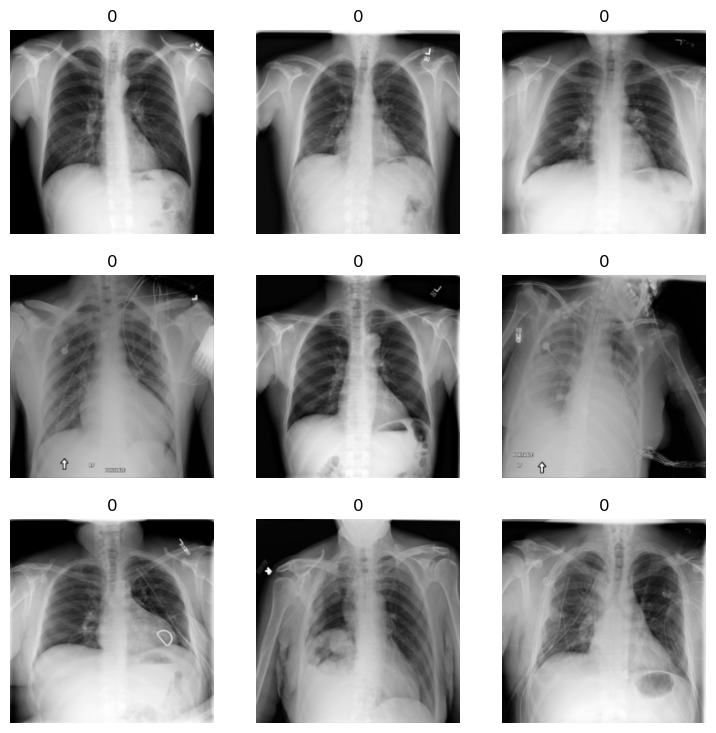

In [68]:
dls.show_batch(cmap='gray')

## CAM

## Detection

## Submission